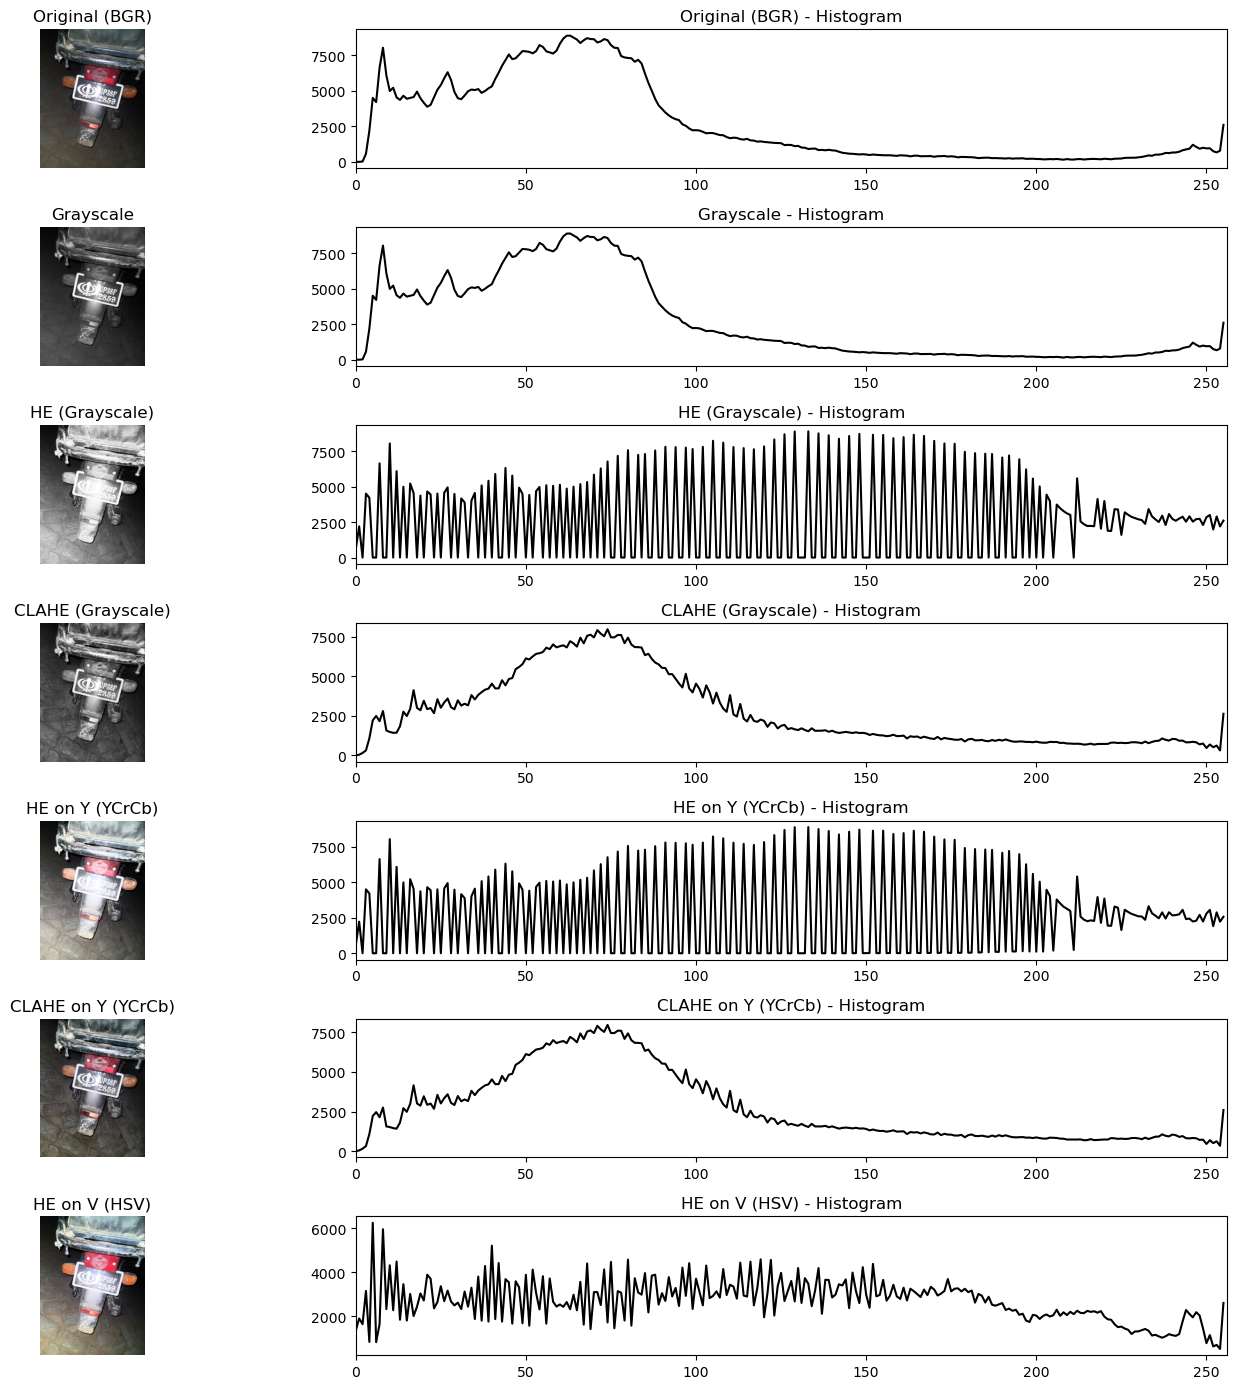

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def load_bgr_resized(path):
    bgr = cv2.imread(path)
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = 720.0/min(h,w); scale = min(1.0, scale)
    return cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

def plot_imgs_and_hists(title_img_pairs, max_cols=3, figsize=(16,10)):
    # For each image, show image and its grayscale histogram
    n = len(title_img_pairs)
    cols = min(max_cols, n)
    rows = n
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(title_img_pairs, 1):
        plt.subplot(rows, 2, 2*i-1)
        if img.ndim == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title); plt.axis('off')
        # histogram
        plt.subplot(rows, 2, 2*i)
        if img.ndim == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        hist = cv2.calcHist([gray],[0],None,[256],[0,256]).ravel()
        plt.plot(hist, color='black'); plt.xlim([0,256]); plt.title(f"{title} - Histogram")
    plt.tight_layout(); plt.show()

def main():
    bgr = load_bgr_resized(IMG_PATH)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # 1) Global Histogram Equalization (grayscale)
    he_gray = cv2.equalizeHist(gray)

    # 2) CLAHE (adaptive HE) to manage local contrast and avoid over‑amplifying noise
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    clahe_gray = clahe.apply(gray)

    # 3) Color-safe equalization on luminance channels
    # 3a) Y channel in YCrCb
    ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y = ycrcb[:,:,0]
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = ycrcb.copy(); ycrcb_eq[:,:,0] = y_eq
    bgr_y_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

    # 3b) CLAHE on Y channel
    y_clahe = clahe.apply(y)
    ycrcb_clahe = ycrcb.copy(); ycrcb_clahe[:,:,0] = y_clahe
    bgr_y_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)

    # 3c) V channel in HSV (alternative)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    v_eq = cv2.equalizeHist(v)
    hsv_eq = hsv.copy(); hsv_eq[:,:,2] = v_eq
    bgr_v_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)

    plot_imgs_and_hists([
        ("Original (BGR)", bgr),
        ("Grayscale", gray),
        ("HE (Grayscale)", he_gray),
        ("CLAHE (Grayscale)", clahe_gray),
        ("HE on Y (YCrCb)", bgr_y_eq),
        ("CLAHE on Y (YCrCb)", bgr_y_clahe),
        ("HE on V (HSV)", bgr_v_eq),
    ], max_cols=3, figsize=(16,14))

if __name__ == "__main__":
    main()
